In [2]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

In [3]:
train_path = 'Dataset/TRAIN'
test_path = 'Dataset/TEST'


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Conv2D,Flatten,BatchNormalization,MaxPooling2D,Dropout,Dense
from tensorflow.keras.preprocessing.image import img_to_array,ImageDataGenerator,load_img 
from tensorflow.keras.utils import plot_model
from glob import glob

In [4]:
x_train = []
y_train = []

for type in glob(train_path+'/*'):
    for img_file in tqdm(glob(type+'/*')):
        img_array = cv2.cvtColor(cv2.imread(img_file),cv2.COLOR_BGR2RGB)
        x_train.append(img_array)
        y_train.append(type.split('/')[-1][-1])
        
        
data = pd.DataFrame({'Image':x_train,'Type':y_train})

100%|██████████| 9999/9999 [00:55<00:00, 178.66it/s]


In [5]:
data.shape

(22564, 2)

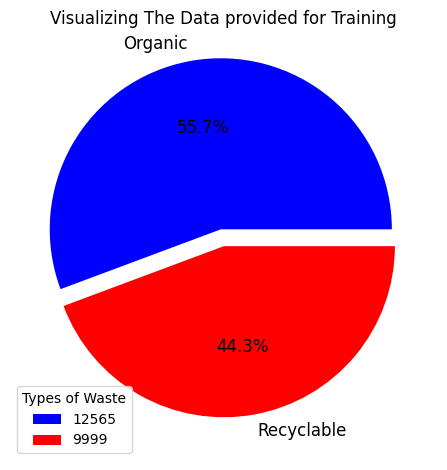

In [6]:
plt.pie(data['Type'].value_counts(),labels=['Organic','Recyclable'],colors=['blue','red'],explode=(0.1,0),textprops={'fontsize':12},autopct='%0.1f%%')
plt.title('Visualizing The Data provided for Training')
plt.legend(data['Type'].value_counts(),title = 'Types of Waste',loc = 'best')
plt.tight_layout()
plt.show()

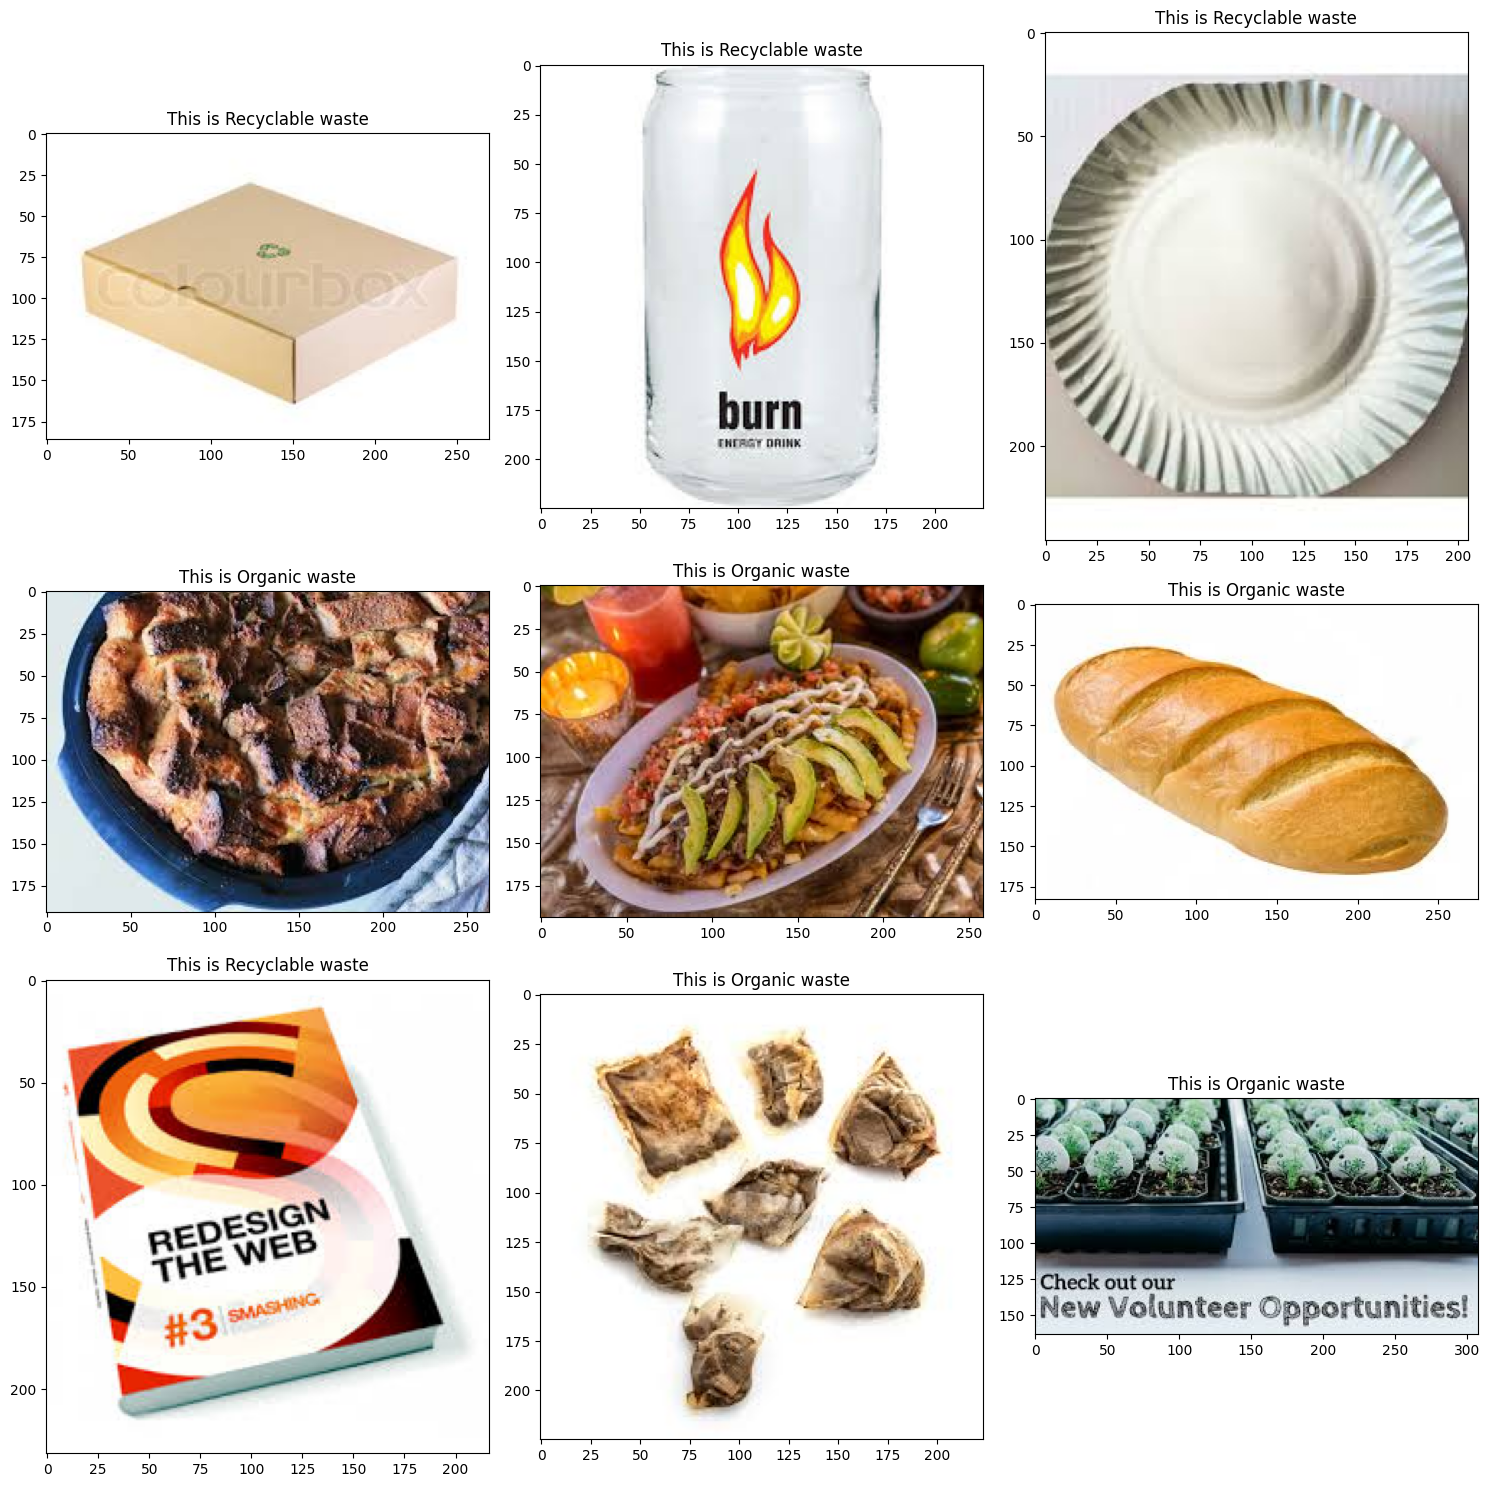

In [7]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    index = np.random.randint(22500)
    plt.title(f'This is {'Recyclable' if data['Type'][index]=='R' else 'Organic'} waste')
    plt.imshow(data['Image'][index])
    plt.tight_layout()
    

In [8]:
model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape = (224,224,3)))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2,activation='sigmoid'))

model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')

batch_size = 256

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,261,250 (84.92 MB)

 Trainable params: 22,261,250 (84.92 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
img_data_gen = ImageDataGenerator(rescale=1./255)

train_gen_data = img_data_gen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size=batch_size,
    color_mode ='rgb',
    class_mode = 'categorical'
)

test_gen_data = img_data_gen.flow_from_directory(
    test_path,
    target_size = (224,224),
    batch_size=batch_size,
    color_mode ='rgb',
    class_mode = 'categorical'
)

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [11]:
hist = model.fit(
    train_gen_data,
    epochs = 10,
    validation_data = test_gen_data
)

Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 249s 3s/step - accuracy: 0.7259 - loss: 0.6090 - val_accuracy: 0.8802 - val_loss: 0.3248
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.8324 - loss: 0.4082 - val_accuracy: 0.8647 - val_loss: 0.3377
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.8510 - loss: 0.3709 - val_accuracy: 0.8830 - val_loss: 0.3048
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 270s 3s/step - accuracy: 0.8620 - loss: 0.3455 - val_accuracy: 0.8695 - val_loss: 0.3198
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.8728 - loss: 0.3217 - val_accuracy: 0.8973 - val_loss: 0.2754
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.8824 - loss: 0.2993 - val_accuracy: 0.8961 - val_loss: 0.2701
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.8957 - loss: 0.2644 - val_accuracy: 0.8949 - val_loss: 0.3094
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.9072 - loss: 0.2374 - val_accuracy: 0.8906 - v